_Lambda School Data Science, Unit 2_
 
# Classification 1 Sprint Challenge: Predict Steph Curry's shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts. (Regular season and playoff games, from October 28, 2009, through June 5, 2019.) 

You'll use information about the shot and the game to predict whether the shot was made. This is hard to predict! Try for an accuracy score in the high 50's or low 60's. The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

In [1]:
import pandas as pd
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url, parse_dates=['game_date']).set_index('game_date')
assert df.shape == (13958, 19)

This Sprint Challenge has two parts. To demonstrate mastery on each part, do all the required, numbered instructions. To earn a score of "3" for the part, also do the stretch goals.

## Part 1. Prepare to model

### Required

1. **Do train/validate/test split.** Use the 2009-10 season through 2016-17 season to train, the 2017-18 season to validate, and the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your train set has 11081 observations, your validation set has 1168 observations, and your test set has 1709 observations.
2. **Begin with baselines for classification.** Your target to predict is `shot_made_flag`. What is the baseline accuracy for the validation set, if you guessed the majority class for every prediction?
3. **Use Ordinal Encoding _or_ One-Hot Encoding,** for the categorical features you select.
4. **Train a Random Forest _or_ Logistic Regression** with the features you select.

### Stretch goals
Engineer at least 4 of these 5 features:

- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?
    

## Part 2. Evaluate models

### Required
1. Get your model's **validation accuracy.** (Multiple times if you try multiple iterations.)
2. Get your model's **test accuracy.** (One time, at the end.)
3. Get and plot your Random Forest's **feature importances** _or_ your Logistic Regression's **coefficients.**
4. Imagine this is the confusion matrix for a binary classification model. **Calculate accuracy, precision, and recall for this confusion matrix:**

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>


### Stretch goals
- Calculate F1 score for the provided, imaginary confusion matrix.
- Plot a real confusion matrix for your basketball model, with row and column labels.
- Print the classification report for your model.

In [2]:
# Load all necessary libraries and set options for viewing data
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', 50)


In [3]:
# Looking at descriptive information for the dataset
df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,htm,vtm,season_type,scoremargin_before_shot
game_date,,,,,,,,,,,,,,,,,,,
2009-10-28,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,GSW,HOU,Regular Season,2.00
2009-10-28,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,GSW,HOU,Regular Season,0.00
2009-10-28,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,GSW,HOU,Regular Season,-4.00
2009-10-28,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,GSW,HOU,Regular Season,-4.00
2009-10-28,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,GSW,HOU,Regular Season,0.00


In [4]:
df.describe(), df.describe(exclude='number')

(          game_id  game_event_id   period  minutes_remaining  \
 count    13958.00       13958.00 13958.00           13958.00   
 mean  24428365.36         270.44     2.41               4.73   
 std    7226619.76         169.93     1.13               3.33   
 min   20900015.00           2.00     1.00               0.00   
 25%   21200912.00         109.00     1.00               2.00   
 50%   21500259.00         275.50     2.00               4.00   
 75%   21700963.00         398.00     3.00               7.00   
 max   41800403.00         752.00     6.00              11.00   
 
        seconds_remaining  shot_distance    loc_x    loc_y  shot_made_flag  \
 count           13958.00       13958.00 13958.00 13958.00        13958.00   
 mean               28.51          17.60    -0.55   131.26            0.47   
 std                17.60          10.30   124.72   102.67            0.50   
 min                 0.00           0.00  -250.00   -41.00            0.00   
 25%                13.

In [5]:
# Create train validate and test data sets
train = df['2009-10':'2017-06']
val = df['2017-10':'2018-06']
test = df['2018-10': '2019-06']

train.shape, val.shape, test.shape

((11081, 19), (1168, 19), (1709, 19))

In [6]:
# Attempt 1st baseline using majority class method
y_train = train['shot_made_flag']
y_train.value_counts(normalize=True)

0   0.53
1   0.47
Name: shot_made_flag, dtype: float64

In [7]:
# Apply majority class to determine accuracy
majority_class = [1]

# Pull in validation shot results to compare
y_val = val['shot_made_flag']

# Create predicted set
y_pred = majority_class * len(y_val)

# Use accuracy score function to compare
from sklearn.metrics import accuracy_score
accuracy_score(y_val, y_pred)

0.4837328767123288

According to initial baseline test above, using majority class as the predicted value netted onlya 48% accuracy score.

In [8]:
# Perform data cleaning and feature engineering to use in model
def wrangle(X):
    # Create fresh copy
    X_Clean = X.copy()
    
    # Remove player name as we know it is only one player
    # Also removing game_id and game_event_id as they are unique
    X_Clean = X_Clean.drop(columns=['player_name','game_id','game_event_id'])
    
    # Add feature to indicate homecourt advantage
    X_Clean['home_advantage'] = np.where(X_Clean['htm'] == 'GSW', 1, 0)
    
    # Add feature to show opponent
    X_Clean['opponent'] = np.where(X_Clean['htm'] == 'GSW', X_Clean['vtm'], X_Clean['htm'])
    
    # Add feature to show total seconds remaining in period
    X_Clean['secs_remaining_per'] = (X_Clean['minutes_remaining'] * 60) + X_Clean['seconds_remaining']
    
    # Add feature to show total seconds remaining in the game
    X_Clean['secs_remaining_game'] = ((4 - X_Clean['period']) * 12 * 60) + X_Clean['secs_remaining_per'] 
    
    return X_Clean
    
    

In [9]:
# Wrangle train, val and test data sets
train_c = wrangle(train)
val_c = wrangle(val)
test_c = wrangle(test)

In [10]:
# Create training features and target feature split
target = 'shot_made_flag'
features_t = train_c.drop(columns=[target]).columns.tolist()



In [11]:
# Create X and Y matrices for regression fit and testing
X_train = train_c[features_t]
Y_train = train_c[target]
X_val = val_c[features_t]
Y_val = val_c[target]
X_test = test_c[features_t]
Y_test = test_c[target]

In [12]:
# Create pipeline for logistic regression classifier model
pipeline_lr = make_pipeline(
                # Use one hot encoder 
                ce.OneHotEncoder(use_cat_names=True), 
                # Use mean imputer
                SimpleImputer(strategy='mean'), 
                # Use logistic regression
                LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=10000)
                )

# Create pipeline for random forest classifier model using ordinal encoding
pipeline_rf = make_pipeline(
                # Use ordinal encoder
                ce.OrdinalEncoder(),
                SimpleImputer(strategy='mean'),
                RandomForestClassifier(n_estimators=100, random_state=23, n_jobs=-1)
)

In [13]:
# Fit logistic regression model on training data set
pipeline_lr.fit(X_train, Y_train)

# Score logistic regression model on validation data set
print('Logistic Regression validation accuracy:', pipeline_lr.score(X_val, Y_val))

Logistic Regression validation accuracy: 0.6215753424657534


In [14]:
# Fit random forest model on training data set
pipeline_rf.fit(X_train, Y_train)

# Score random forest model on validation data set
print('Random Forest validation accuracy:', pipeline_rf.score(X_val, Y_val))

Random Forest validation accuracy: 0.5804794520547946


Based on the initial runs of the 2 classification models, Logistic Regression is more accurate.

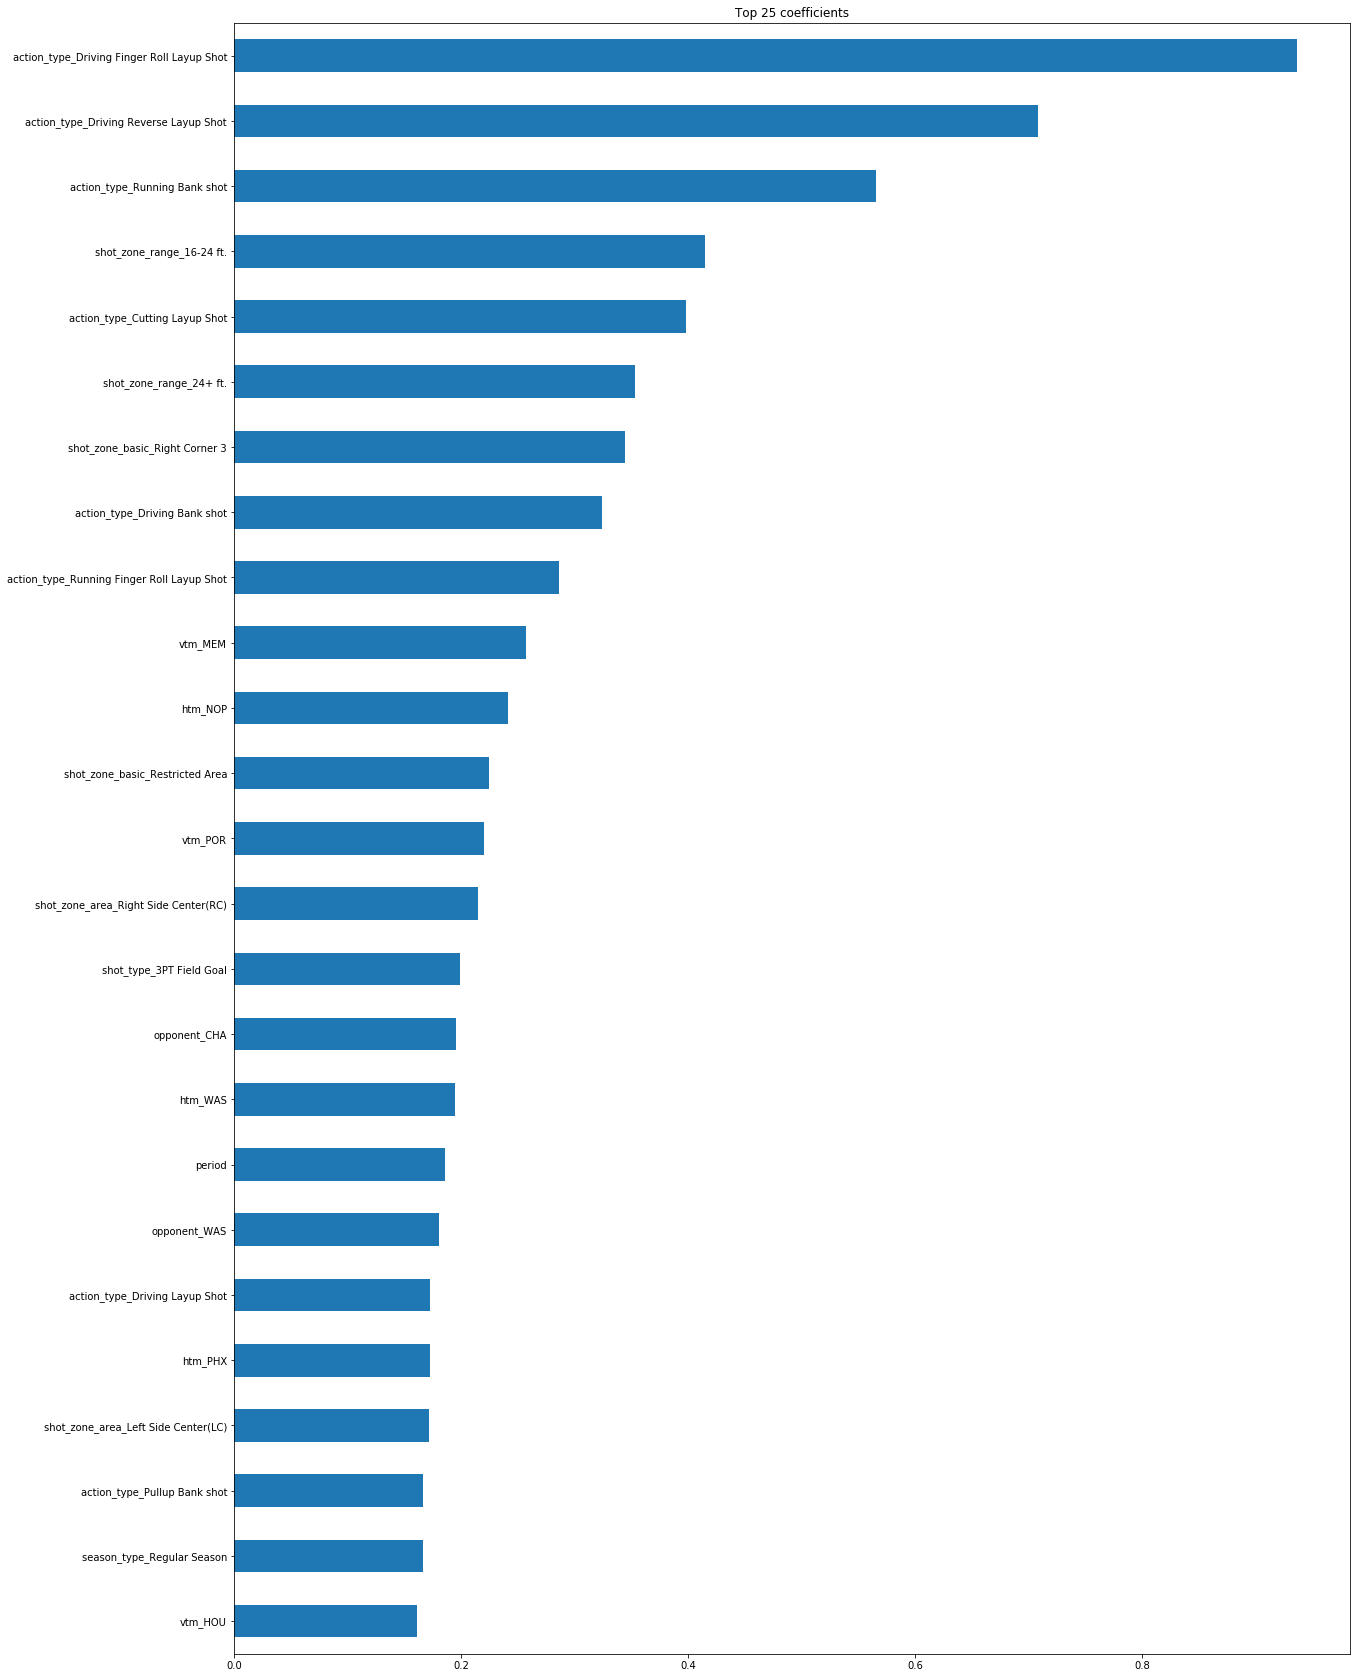

In [15]:
# Pull coefficients for logistic regression
pipeline_lr.named_steps

# Pull information from pipeline
encoder = pipeline_lr.named_steps['onehotencoder']
lr = pipeline_lr.named_steps['logisticregression']
feat_names = encoder.transform(X_val).columns
lr_coef = pd.Series(lr.coef_[0], feat_names)

# Plot coefficients
n = 25
plt.figure(figsize=(20, 30))
plt.title(f'Top {n} coefficients')
lr_coef.sort_values()[-n:].plot.barh();

In [16]:
# Pull coefficients for logistic regression
pipeline_rf.named_steps

{'ordinalencoder': OrdinalEncoder(cols=['action_type', 'shot_type', 'shot_zone_basic', 'shot_zone_area', 'shot_zone_range', 'htm', 'vtm', 'season_type', 'opponent'],
         drop_invariant=False, handle_missing='value',
         handle_unknown='value',
         mapping=[{'col': 'action_type', 'mapping': Jump Shot                              1
 Step Back Jump shot                    2
 Pullup Jump shot                       3
 Layup Shot                             4
 Jump Bank Shot                         5
 Driving Layup Shot                     6
 Reverse Lay...
 ATL    27
 TOR    28
 NYK    29
 BKN    30
 NOP    31
 NaN    -2
 dtype: int64, 'data_type': dtype('O')}],
         return_df=True, verbose=0),
 'simpleimputer': SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean',
        verbose=0),
 'randomforestclassifier': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nod

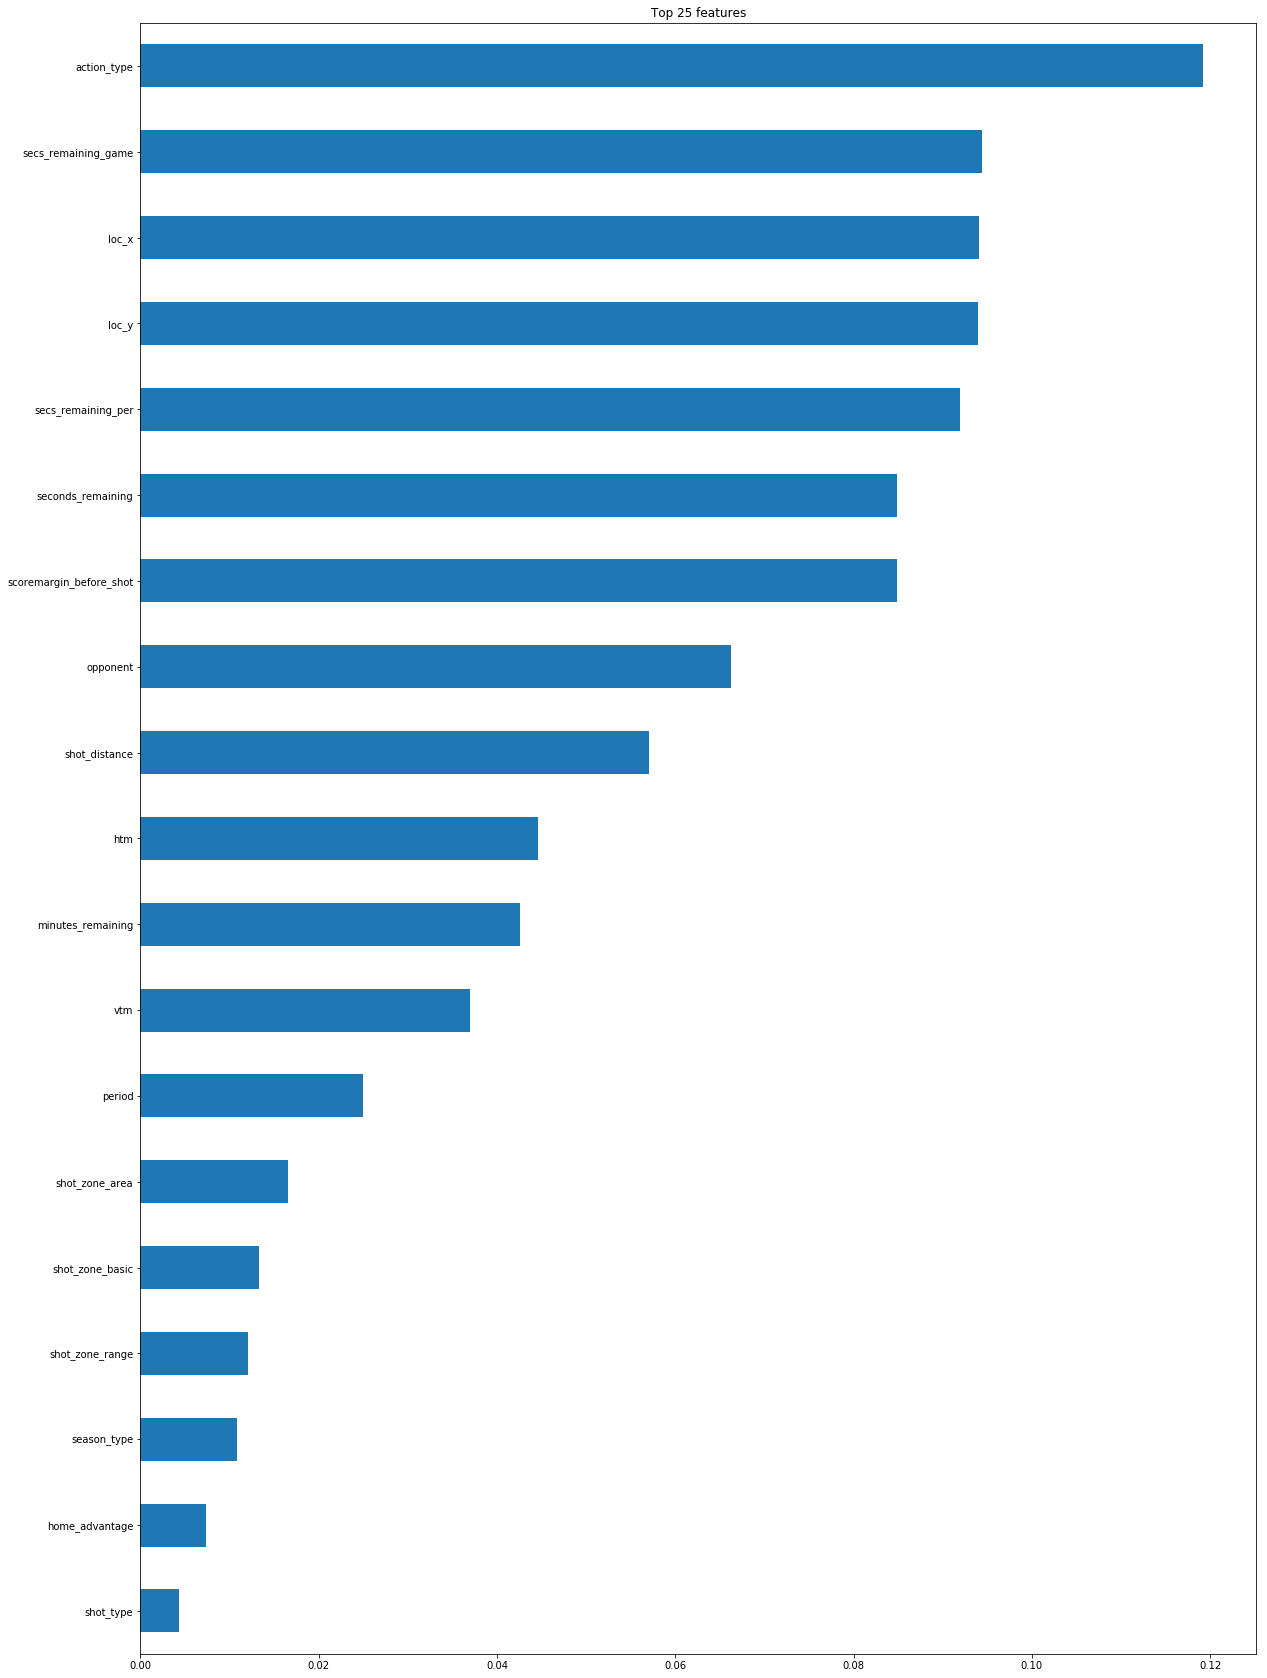

In [17]:
# Pull information from pipeline
encoder = pipeline_rf.named_steps['ordinalencoder']
rf = pipeline_rf.named_steps['randomforestclassifier']
feat_names = encoder.transform(X_val).columns
rf_importances = pd.Series(rf.feature_importances_, feat_names)

# Plot coefficients
n = 25
plt.figure(figsize=(20, 30))
plt.title(f'Top {n} features')
rf_importances.sort_values()[-n:].plot.barh();

In [18]:
# Perform prediction on test set
y_pred_lr = pipeline_lr.predict(X_test)

print('The accuracy on the test set using logistic regression is:', pipeline_lr.score(X_test,Y_test))

The accuracy on the test set using logistic regression is: 0.6272674078408426


### Question 4 of part 2

In [19]:
# Calculate Accuracy of given matrix
correct_preds = 85 + 36
total_preds = 85+ 58 + 8 + 36
accuracy = correct_preds/total_preds

print('The accuracy for the matrix is:', accuracy)

The accuracy for the matrix is: 0.6470588235294118


In [20]:
# Calculate precision for Negative
correct_preds_neg = 85
total_preds_neg = 85 + 6
precision_neg = correct_preds_neg/total_preds_neg

# Calculate precision for Positive
correct_preds_pos = 36
total_preds_pos = 58 + 36
precision_pos = correct_preds_pos/total_preds_neg

print('The precision values for the matrix are as follows:\n', 'Negative:', precision_neg, 
      '\n', 'Positive:', precision_pos)

The precision values for the matrix are as follows:
 Negative: 0.9340659340659341 
 Positive: 0.3956043956043956


In [21]:
# Calculate recall for matrix
actual_neg = 85 + 58
actual_pos = 8 + 36

recall_neg = correct_preds_neg/actual_neg
recall_pos = correct_preds_pos/actual_pos

print('The recall vales for the matrix are as follows:\n', 'Negative:', recall_neg,
      '\n', 'Positive:', recall_pos)

The recall vales for the matrix are as follows:
 Negative: 0.5944055944055944 
 Positive: 0.8181818181818182
